#### Data Cleaning After WEB SCRAPING the File

In [1]:
import numpy as np
import pandas as pd

import re
import seaborn as sns
import matplotlib.pyplot as plt

import ipywidgets as widgets
from IPython.display import display
from num2words import num2words
from wordcloud import WordCloud

In [2]:
Data = pd.read_csv("Dataset1.csv")
Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3052 entries, 0 to 3051
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        3052 non-null   int64 
 1   Date              3052 non-null   object
 2   Year              3052 non-null   object
 3   Startup_Name      3040 non-null   object
 4   IndustryVertical  3040 non-null   object
 5   SubVertical       2275 non-null   object
 6   CityLocation      3031 non-null   object
 7   Investors Name    3016 non-null   object
 8   Amt (in USD)      2094 non-null   object
 9   InvestmentType    3033 non-null   object
dtypes: int64(1), object(9)
memory usage: 238.6+ KB


In [3]:
# Cleaning IndustryVertical Column

Data['IndustryVertical'] = Data['IndustryVertical'].fillna(value='Others') # Filling the empty cells with Others
Data['IndustryVertical'] = Data['IndustryVertical'].replace(['ECommerce', 'E-commerce', 'eCommerce', 'E-commerce'], 'E-Commerce')

# Cleaning CityLocation Column

Data['CityLocation'] = Data['CityLocation'].fillna(value='Not Available')  # Filling the empty cells which are not available
Data['CityLocation'] = Data['CityLocation'].str.replace(' and ', ',') # (and) Replacing with ( , )
Data['CityLocation'] = Data['CityLocation'].str.replace(' & ', ',') # (&) Replacing with ( , )
Data['CityLocation'] = Data['CityLocation'].str.split(',').str[0].str.strip() # (,) Spliting and Striping remaining
Data['CityLocation'] = Data['CityLocation'].replace(['Bangalore'], 'Bengaluru')

Data['Investors Name'] = Data['Investors Name'].fillna(value='Unknown') 

# Cleaning InvestType Column

Data['InvestmentType'] = Data['InvestmentType'].fillna(value='Not Available')  # Filling the empty cells which are not available
Data['InvestmentType'] = Data['InvestmentType'].str.split('/').str[0].str.strip() # (/) Spliting and Striping remaining
Data['Year'] = Data['Year'].str.replace('/015', '2015')

drop = [2043, 2113, 2115, 2186, 2189, 2211, 2224, 2227, 2234, 2237, 2253, 2689]
Data = Data.drop(drop)

In [4]:
Data['Amt (in USD)'].replace(['Undisclosed', 'undisclosed', 'unknown'], '', inplace=True)
Data['Amt (in USD)'] = Data['Amt (in USD)'].astype(str).str.replace(',', '').str.replace('+', '')

replace = {
    '75000000-100000000': '75000000',
    'upto 15000000': '15000000',
    'upto 8900000': '8900000'
}
Data['Amt (in USD)'] = Data['Amt (in USD)'].replace(replace)

In [5]:
Data['Amt (in USD)'] = pd.to_numeric(Data['Amt (in USD)'], errors='coerce')
mean = Data.groupby('Year')['Amt (in USD)'].transform('mean')
Data['Amt (in USD)'].fillna(mean, inplace=True)

In [6]:
# Convert amount in words
def convert(amount):
    try:
        amount = int(amount)  # Try converting to int 
    except ValueError:
        try:
            amount = float(amount.replace(',', '')) 
        except ValueError:
            return 'Undisclosed'  
    if amount >= 1_000_000:
        return str(int(amount / 1_000_000)) + 'M'
    elif amount >= 1_000:
        return str(int(amount / 1_000)) + 'K'
    else:
        return str(amount)

Data['Amount'] = Data['Amt (in USD)'].apply(convert)

In [7]:
separator = ','

# Splitting the cells for multiple investors based on the separator
Data['Investors'] = Data['Investors Name'].str.split(separator)

# Counting number of investors for each startup
Data['Total Investors'] = Data['Investors'].apply(lambda x: len(x) if isinstance(x, list) else 1)

# Creating new column first investor
Data['First Investor'] = Data['Investors'].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else None)
replace = {
    'Un disclosed investors': 'Undisclosed investor',
    'Undisclosed': 'Undisclosed investor',
    'undisclosed investors': 'Undisclosed investor',
    'Undisclosed Investors': 'Undisclosed investor'
}
Data['First Investor'] = Data['First Investor'].replace(replace)

Data.info()
Data.to_csv("cms.csv")

<class 'pandas.core.frame.DataFrame'>
Index: 3040 entries, 0 to 3051
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        3040 non-null   int64  
 1   Date              3040 non-null   object 
 2   Year              3040 non-null   object 
 3   Startup_Name      3040 non-null   object 
 4   IndustryVertical  3040 non-null   object 
 5   SubVertical       2275 non-null   object 
 6   CityLocation      3040 non-null   object 
 7   Investors Name    3040 non-null   object 
 8   Amt (in USD)      3040 non-null   float64
 9   InvestmentType    3040 non-null   object 
 10  Amount            3040 non-null   object 
 11  Investors         3040 non-null   object 
 12  Total Investors   3040 non-null   int64  
 13  First Investor    3040 non-null   object 
dtypes: float64(1), int64(2), object(11)
memory usage: 356.2+ KB


In [8]:
Data.drop(columns=["Unnamed: 0", "Investors Name"], inplace=True)

# Rearrange the columns
Data = Data[["Date", "Year", "Startup_Name", "IndustryVertical", "SubVertical", 
             "CityLocation","Investors","First Investor","Total Investors","Amt (in USD)", "Amount", "InvestmentType"]]

In [9]:
investment_types = {
    'Series F': 'Series',
    'Series E': 'Series',
    'Series J': 'Series',
    'Series D': 'Series',
    'Venture': 'Venture Capital',
    'Debt Financing': 'Debt',
    'Seed': 'Seed Funding',
    'Series A': 'Series',
    'Series B': 'Series',
    'Series C': 'Series',
    'Unspecified': 'Other',
    'Venture Round': 'Venture Capital',
    'Seed Funding': 'Seed Funding',
    'Series': 'Series',
    'Funding': 'Other',
    'Secondary Market': 'Other',
    'Bridge Funding': 'Other',
    'Pre-series E': 'Pre-Series',
    'Pre-Series A': 'Pre-Series',
    'Equity and Debt': 'Other',
    'Debt': 'Debt',
    'Not Available': 'Other',
    'Follow-On': 'Other',
    'Private Equity': 'Private Equity',
    'Angel': 'Angel Funding',
    'In Progress': 'Other',
    'Series D1': 'Series',
    'M&A': 'Other',
    'pre-Series A': 'Pre-Series',
    'pre-Series B': 'Pre-Series',
    'Venture-Series Unknown': 'Venture Capital',
    'pre-Seed': 'Pre-Series',
    'Venture - Series Unknown': 'Venture Capital',
    'Pre Seed': 'Pre-Series',
    'Series C1': 'Series',
    'Series 1': 'Series',
    'Venture Series': 'Venture Capital',
    'Private Equity Round': 'Private Equity',
    'Pre-series A': 'Pre-Series',
    'Seed Round': 'Seed Funding',
    'Debt Funding': 'Debt',
    'Series G': 'Series',
    'Series H': 'Series',
    'Funding Round': 'Other',
    'Maiden Round': 'Other',
    'pre-series A': 'Pre-Series',
    'Seed Funding Round': 'Seed Funding',
    'Single Venture': 'Other',
    'Corporate Round': 'Other',
    'Angel Round': 'Angel Funding',
    'Debt and Preference capital': 'Debt',
    'Inhouse Funding': 'Other',
    'Equity': 'Other',
    'Debt-Funding': 'Debt',
    'Mezzanine': 'Other',
    'Series B (Extension)': 'Series',
    'Equity Based Funding': 'Other',
    'Private Funding': 'Private Equity',
    'PrivateEquity': 'Private Equity',
    'Structured Debt': 'Debt',
    'Term Loan': 'Debt',
    'Private': 'Private Equity',
    'Pre Series A': 'Pre-Series',
    'Bridge Round': 'Other',
    'Personal Investment': 'Other'
}

# Replace alternative investment types with single types
Data['InvestmentType'] = Data['InvestmentType'].replace(investment_types)
Data.to_csv("Indian Startup Funding.csv")

#### ----------------------------------------------------------- Cleaning is Completed -----------------------------------------------

### Exploratory Data Analysis (EDA) from here

In [83]:
Data = pd.read_csv("Indian Startup Funding.csv")
Data.drop(columns=["Unnamed: 0", "SubVertical"], inplace=True)
print(Data.shape)
Data.head(7)

(3040, 11)


,Date,Year,Startup_Name,IndustryVertical,CityLocation,Investors,First Investor,Total Investors,Amt (in USD),Amount,InvestmentType
0,01/04/2021,2021,BYJU’S,Edu-tech,Bengaluru,['Innoven Capital'],Innoven Capital,1,460000000.0,460M,Series
1,05/04/2021,2021,Meesho,E-Commerce,Bengaluru,['SoftBank Vision Fund 2'],SoftBank Vision Fund 2,1,300000000.0,300M,Series
2,14/04/2021,2021,Swiggy,Online Food Delivery,Bengaluru,"['Amansa Holdings', ' Carmignac', ' Falcon Edg...",Amansa Holdings,5,343000000.0,343M,Series
3,07/04/2021,2021,Groww,FinTech,Bengaluru,"['MC Global Edtech', ' B Capital', ' Baron', '...",MC Global Edtech,4,83000000.0,83M,Series
4,14/04/2021,2021,Beldara,E-Commerce,Mumbai,['Hindustan Media Ventures'],Hindustan Media Ventures,1,7400000.0,7M,Venture Capital
5,04/03/2021,2021,DealShare,E-Commerce,Jaipur,['Innoven Capital'],Innoven Capital,1,250000000.0,250M,Debt
6,31/03/2021,2021,Uniphore,Technology,Palo Alto,['Sorenson Capital Partners'],Sorenson Capital Partners,1,140000000.0,140M,Series


In [89]:
Data['Date'] = pd.to_datetime(Data['Date'], format='%d/%m/%Y')
Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3040 entries, 0 to 3039
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              3040 non-null   datetime64[ns]
 1   Year              3040 non-null   int64         
 2   Startup_Name      3040 non-null   object        
 3   IndustryVertical  3040 non-null   object        
 4   CityLocation      3040 non-null   object        
 5   Investors         3040 non-null   object        
 6   First Investor    3040 non-null   object        
 7   Total Investors   3040 non-null   int64         
 8   Amt (in USD)      3040 non-null   float64       
 9   Amount            3040 non-null   object        
 10  InvestmentType    3040 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(7)
memory usage: 261.4+ KB


In [90]:
pd.DataFrame(Data.isnull().sum())

,0
Date,0
Year,0
Startup_Name,0
IndustryVertical,0
CityLocation,0
Investors,0
First Investor,0
Total Investors,0
Amt (in USD),0
Amount,0


#### 1. Basic Statistics :

In [91]:
Amount = Data['Amt (in USD)'].describe()

print("- Count: {:,.0f}".format(Amount['count']))
print("- Mean: ${:,.2f}M".format(Amount['mean']/1e6))
print("- Std: ${:,.2f}M".format(Amount['std']/1e6))
print("- Min: ${:,.0f}".format(Amount['min']))
print("- 25%: ${:,.0f}".format(Amount['25%']))
print("- 50%: ${:,.0f}".format(Amount['50%']))
print("- 75%: ${:,.2f}M".format(Amount['75%']/1e6))
print("- Max: ${:,.1f}B".format(Amount['max']/1e9))

- Count: 3,040
- Mean: $18.80M
- Std: $104.27M
- Min: $18,000
- 25%: $1,000,000
- 50%: $6,445,311
- 75%: $14.23M
- Max: $3.9B


In [92]:
cities = Data["CityLocation"].value_counts().head(10)
cities

CityLocation
Bengaluru    908
Mumbai       595
New Delhi    440
Gurgaon      308
Pune         113
Hyderabad    102
Chennai       99
Noida         97
Gurugram      58
Ahmedabad     39
Name: count, dtype: int64

In [93]:
investors = cities = Data["First Investor"].value_counts().head(10)
investors

First Investor
Undisclosed investor     66
Accel Partners           48
Sequoia Capital          40
Indian Angel Network     34
Undisclosed investors    32
Kalaari Capital          30
Ratan Tata               27
Blume Ventures           25
Unknown                  24
SAIF Partners            21
Name: count, dtype: int64

In [94]:
investment_types = cities = Data["InvestmentType"].value_counts()
investment_type

InvestmentType
Seed Funding       1486
Private Equity     1289
Series              140
Debt                 37
Other                30
Pre-Series           21
Venture Capital      19
Angel Funding        17
Seed funding          1
Name: count, dtype: int64

In [95]:
Data["CityLocation"].unique()

array(['Bengaluru', 'Mumbai', 'Jaipur', 'Palo Alto', 'Gurgaon', 'London',
       'New Delhi', 'Patna', 'Pune', 'Noida', 'Washington', 'Gurugram',
       'Wilmington', 'Newark', 'Stanford', 'Singapore', 'New York',
       'Chennai', 'Ahmedabad', 'Bhopal', 'Hyderabad',
       'San Francisco/ Bangalore', 'Faridabad', 'San Francisco',
       'San Jose', 'Amritsar', 'Delhi', 'Kormangala', 'Tulangan',
       'Burnsville', 'Menlo Park', 'Santa Monica', 'Taramani', 'Andheri',
       'Chembur', 'Nairobi', 'Haryana', 'Karnataka', 'Mumbai/Bengaluru',
       'India/Singapore', 'India/US', 'Nagpur', 'Indore', 'California',
       'India', 'Ahemadabad', 'Rourkela', 'Kolkata', 'SFO / Bangalore',
       'Vadodara', 'Coimbatore', 'Not Available', 'Seattle / Bangalore',
       'Panaji', 'Pune / Dubai', 'Srinagar', 'US', 'Goa', 'Kochi',
       'Bangalore / SFO', 'Varanasi', 'Trivandrum', 'Ahemdabad', 'Kerala',
       'Lucknow', 'Bhubneswar', 'Bangalore/ Bangkok', 'Bhubaneswar',
       'Siliguri', 'Surat'

In [96]:
Data["InvestmentType"].unique()

array(['Series', 'Venture Capital', 'Debt', 'Seed Funding', 'Other',
       'Pre-Series', 'Private Equity', 'Angel Funding', 'Seed funding'],
      dtype=object)

In [97]:
Data["First Investor"].unique()

array(['Innoven Capital', 'SoftBank Vision Fund 2', 'Amansa Holdings',
       ..., 'Vectr Ventures', 'Collaborative Licensing Ventures LLP',
       'Sharad Hegde'], dtype=object)

#### 2. Time Analysis

In [98]:
Data['Year'] = Data['Date'].dt.year
startups = Data['Year'].value_counts().sort_index()
print(startups)

Year
2015     765
2016    1018
2017     687
2018     310
2019     111
2020     120
2021      29
Name: count, dtype: int64


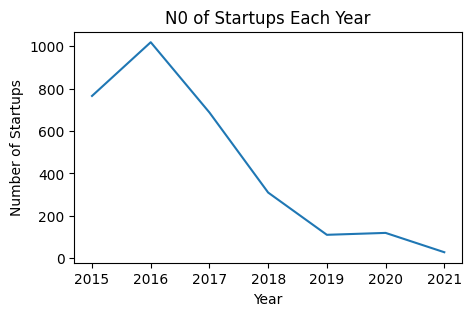

In [99]:
plt.figure(figsize=(5, 3))
sns.lineplot(x=startups.index, y=startups.values)
plt.title('N0 of Startups Each Year')
plt.xlabel('Year')
plt.ylabel('Number of Startups')
plt.show()

#### 3. Industry Analysis

In [100]:
def format_short(number):
    magnitude = 0
    while abs(number) >= 1000:
        magnitude += 1
        number /= 1000.0
    return '%.2f%s' % (number, ['', 'K', 'M', 'B'][magnitude])

In [101]:
industries = Data.groupby('IndustryVertical')['Amt (in USD)'].sum().sort_values(ascending=False).head(10)
industries = industries.apply(format_short)
print(industries)

IndustryVertical
E-Commerce             11.70B
Consumer Internet      10.50B
Technology              5.08B
Transportation          3.96B
Finance                 2.14B
FinTech                 1.52B
Edu-tech                1.22B
EduTech               802.72M
Healthcare            773.27M
Online Marketplace    700.14M
Name: Amt (in USD), dtype: object


In [62]:
Investments = Data.groupby('InvestmentType')['Amt (in USD)'].mean().sort_values(ascending=False)
Investments = Investments.apply(format_short)
print(Investments)

InvestmentType
Other              109.62M
Series              84.10M
Venture Capital     31.95M
Private Equity      23.52M
Seed funding        19.33M
Angel Funding       17.57M
Debt                15.57M
Pre-Series          11.21M
Seed Funding         6.75M
Name: Amt (in USD), dtype: object


#### 4. Location Analysis

In [102]:
cities = Data['CityLocation'].value_counts().head(5)
print(cities)

CityLocation
Bengaluru    908
Mumbai       595
New Delhi    440
Gurgaon      308
Pune         113
Name: count, dtype: int64


#### 5. Investor Analysis

In [103]:
investors = Data['First Investor'].explode().value_counts().head(5)
print(investors)

First Investor
Undisclosed investor     66
Accel Partners           48
Sequoia Capital          40
Indian Angel Network     34
Undisclosed investors    32
Name: count, dtype: int64


#### 6. Investment Type Analysis

In [104]:
investment_type = Data['InvestmentType'].value_counts()
print(investment_type)

InvestmentType
Seed Funding       1486
Private Equity     1289
Series              140
Debt                 37
Other                30
Pre-Series           21
Venture Capital      19
Angel Funding        17
Seed funding          1
Name: count, dtype: int64


#### 7. Missing Values

In [105]:
print(Data.isnull().sum())

Date                0
Year                0
Startup_Name        0
IndustryVertical    0
CityLocation        0
Investors           0
First Investor      0
Total Investors     0
Amt (in USD)        0
Amount              0
InvestmentType      0
dtype: int64


#### 8. Visualization:

##### A. The no. of Count in investments by year

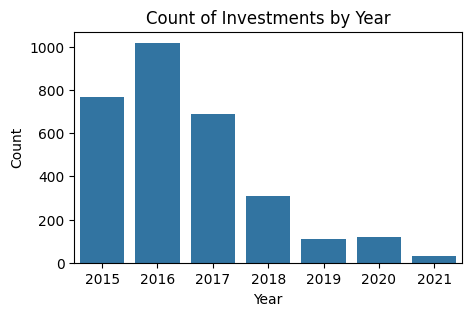

In [106]:
plt.figure(figsize=(5, 3))
sns.countplot(x='Year', data=Data)
plt.title('Count of Investments by Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.show()

##### B. The total funding amount varied over the years?

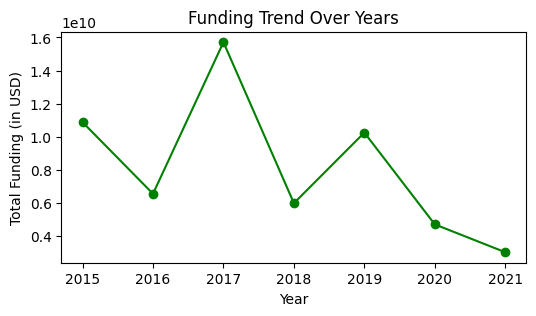

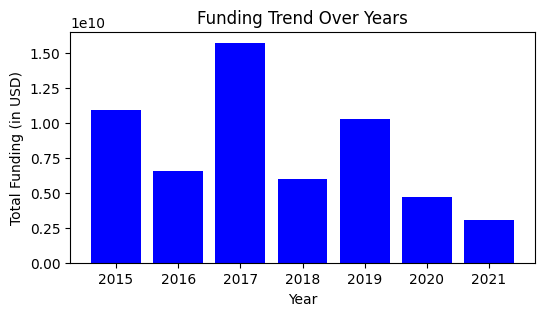

In [107]:
funding_trend = Data.groupby('Year')['Amt (in USD)'].sum()

# Line Plot
plt.figure(figsize=(6, 3))
funding_trend.plot(marker='o', color='green')
plt.title('Funding Trend Over Years')
plt.xlabel('Year')
plt.ylabel('Total Funding (in USD)')
plt.show()


# Bar Plot
plt.figure(figsize=(6, 3))
plt.bar(funding_trend.index, funding_trend.values, color='blue')
plt.title('Funding Trend Over Years')
plt.xlabel('Year')
plt.ylabel('Total Funding (in USD)')
plt.show()

##### C. The common types of investments made in startups?

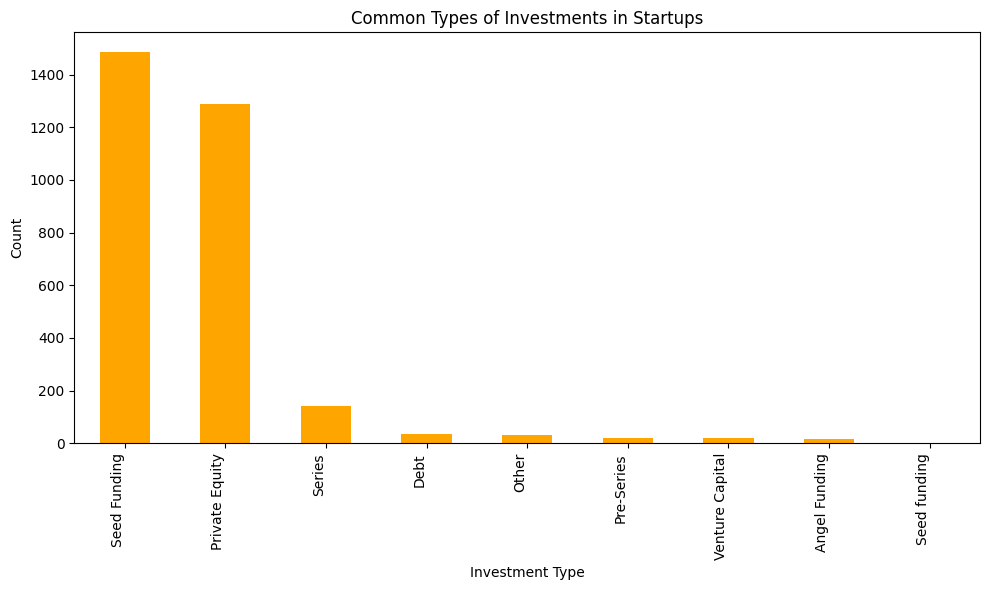

In [108]:
investment_types = Data['InvestmentType'].value_counts()

plt.figure(figsize=(10, 6))
investment_types.plot(kind='bar', color='orange')
plt.title('Common Types of Investments in Startups')
plt.xlabel('Investment Type')
plt.ylabel('Count')
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()

##### D. The distribution of total investors grouped by investment type.


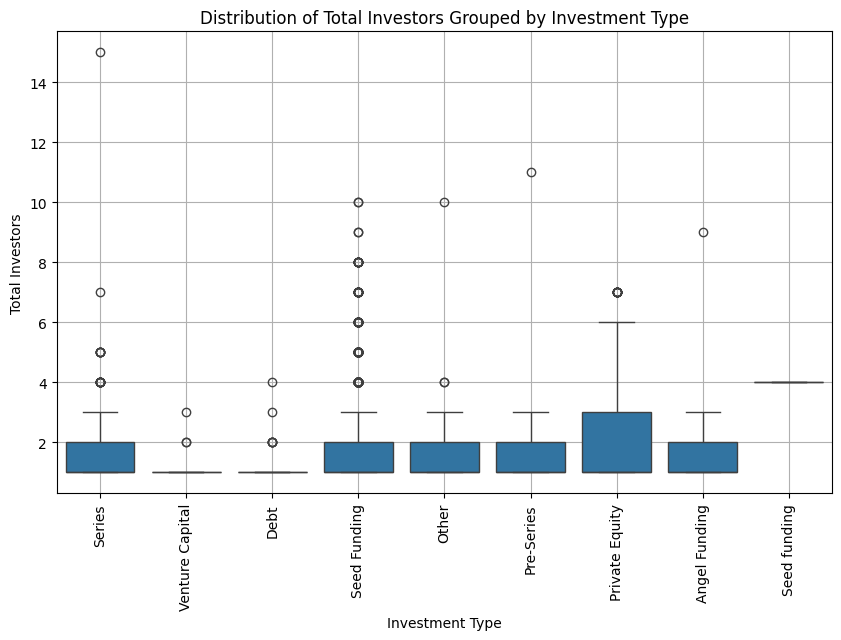

In [72]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='InvestmentType', y='Total Investors', data=Data)
plt.title('Distribution of Total Investors Grouped by Investment Type')
plt.xlabel('Investment Type')
plt.ylabel('Total Investors')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

##### F. Correlation between the total number of investors and the amount of funding raised

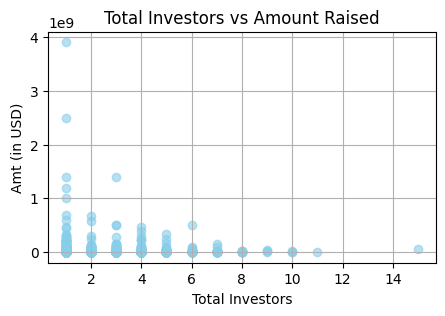

Correlation between total number of investors and amount raised: 0.001788066895333607


In [28]:
plt.figure(figsize=(5, 3))
plt.scatter(Data['Total Investors'], Data['Amt (in USD)'], color='skyblue', alpha=0.6)
plt.title('Total Investors vs Amount Raised')
plt.xlabel('Total Investors')
plt.ylabel('Amt (in USD)')
plt.grid(True)
plt.show()

correlation = Data['Total Investors'].corr(Data['Amt (in USD)'])
print("Correlation between total number of investors and amount raised:", correlation)

##### G. The top investors in the startup ecosystem?

C:\Users\N Sri Kumar Raju\AppData\Local\Temp\ipykernel_15128\4005521882.py:10: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


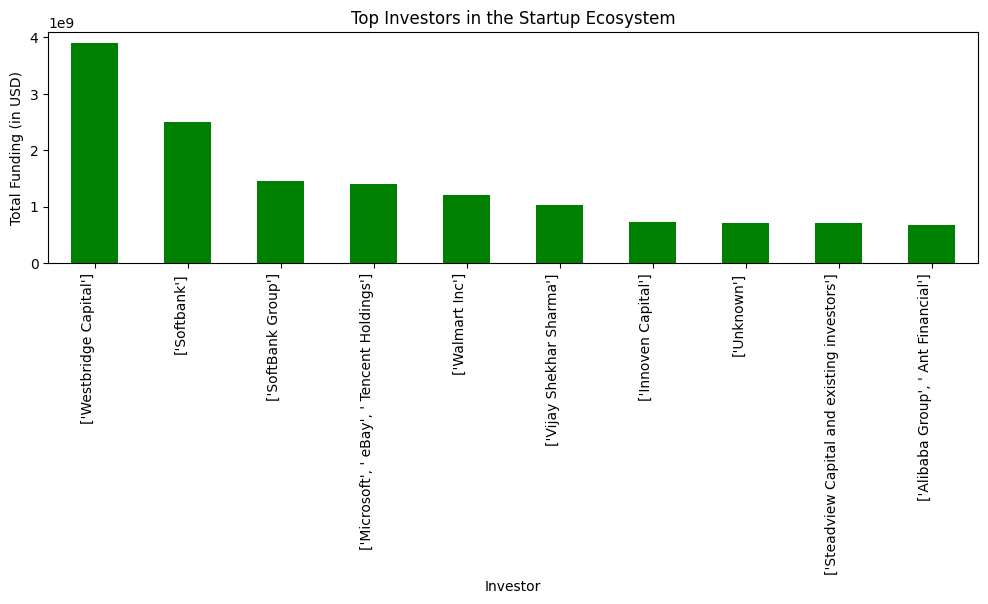

In [77]:
Data_exploded = Data.explode('Investors')
top_investors = Data_exploded.groupby('Investors')['Amt (in USD)'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 3))
top_investors.plot(kind='bar', color='green')
plt.title('Top Investors in the Startup Ecosystem')
plt.xlabel('Investor')
plt.ylabel('Total Funding (in USD)')
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()

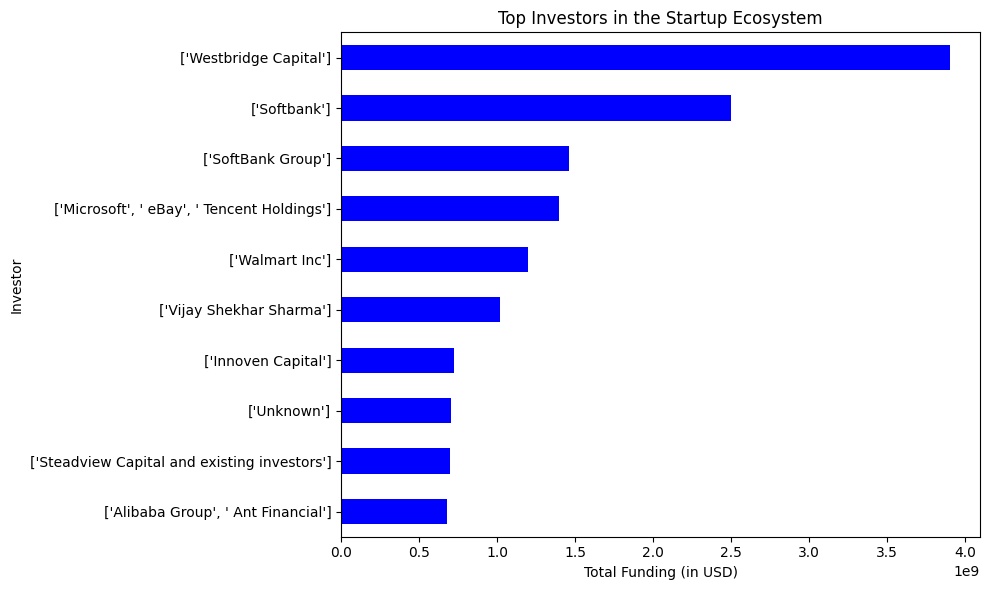

In [109]:
plt.figure(figsize=(10, 6))
top_investors.sort_values().plot(kind='barh', color='blue')
plt.title('Top Investors in the Startup Ecosystem')
plt.xlabel('Total Funding (in USD)')
plt.ylabel('Investor')
plt.tight_layout()
plt.show()

##### H. Top 10 investors by the number of investments?

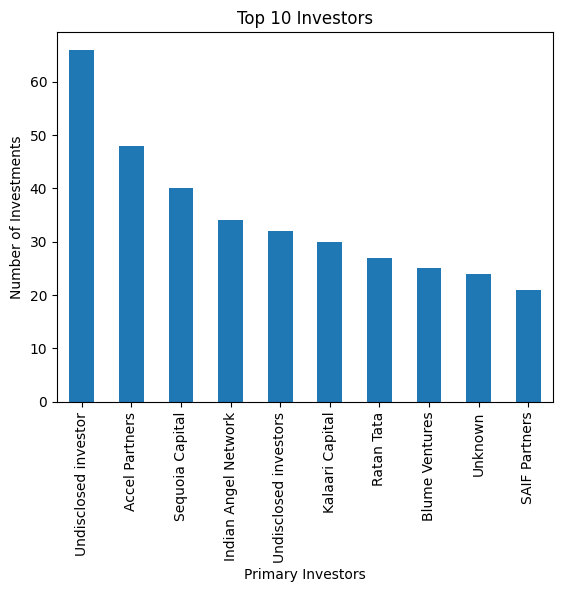

In [110]:
investors = Data['First Investor'].explode().value_counts().nlargest(10)
investors.plot(kind='bar')
plt.title('Top 10 Investors')
plt.xlabel('Primary Investors')
plt.ylabel('Number of Investments')
plt.xticks(rotation=90)
plt.show()

##### I. First investor appears most frequently?

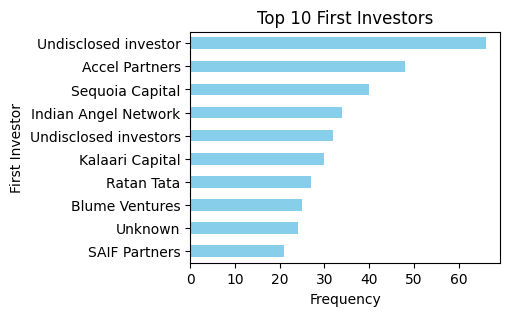

In [111]:
investor_counts = Data['First Investor'].value_counts()
top_10_investors = investor_counts.head(10)

plt.figure(figsize=(4, 3))
top_10_investors.sort_values().plot(kind='barh', color='skyblue')
plt.title('Top 10 First Investors')
plt.xlabel('Frequency')
plt.ylabel('First Investor')
plt.show()

##### J. Cities have the Highest Startups?

CityLocation
Bengaluru    2.684615e+10
Mumbai       7.554906e+09
New Delhi    5.544819e+09
Gurgaon      5.082939e+09
Noida        1.871064e+09
Pune         1.560128e+09
Gurugram     1.069580e+09
Chennai      1.037538e+09
Hyderabad    8.676761e+08
Jaipur       5.793465e+08
Name: Amt (in USD), dtype: float64


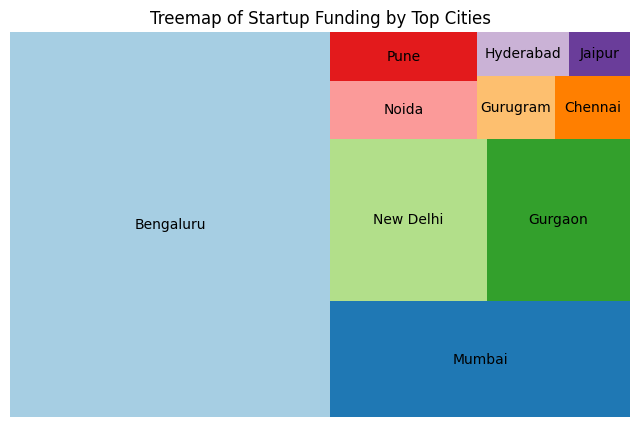

In [112]:
import squarify
city_funding = Data.groupby('CityLocation')['Amt (in USD)'].sum()

top_cities = city_funding.sort_values(ascending=False).head(10)
print(top_cities)

plt.figure(figsize=(8, 5))
squarify.plot(sizes=top_cities.values, label=top_cities.index, color=sns.color_palette('Paired'))
plt.axis('off')
plt.title('Treemap of Startup Funding by Top Cities')
plt.show()

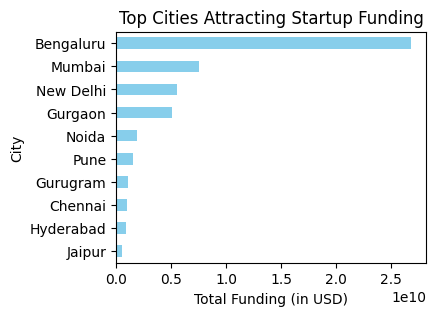

In [113]:
plt.figure(figsize=(4, 3))
top_cities.sort_values().plot(kind='barh', color='skyblue')
plt.title('Top Cities Attracting Startup Funding')
plt.xlabel('Total Funding (in USD)')
plt.ylabel('City')
plt.show()


##### K. The top 5 industries by the number of startups?

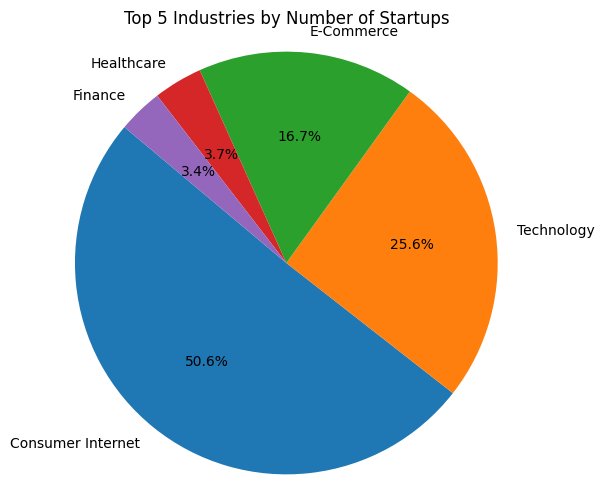

In [114]:
industries = Data['IndustryVertical'].value_counts().nlargest(5)

plt.figure(figsize=(6, 6))
plt.pie(industries, labels=industries.index, autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.title('Top 5 Industries by Number of Startups')
plt.show()


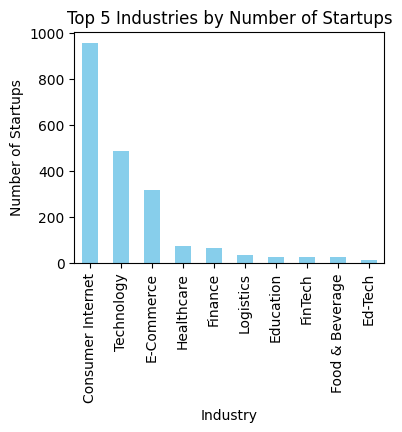

In [35]:
top_industries = Data['IndustryVertical'].value_counts().nlargest(10)

plt.figure(figsize=(4, 3))
top_industries.plot(kind='bar', color='skyblue')
plt.title('Top 5 Industries by Number of Startups')
plt.xlabel('Industry')
plt.ylabel('Number of Startups')
plt.show()

##### L. industries have received the most funding?

In [36]:
funding = Data.groupby('IndustryVertical')['Amt (in USD)'].sum().reset_index()
industry_funding = funding.sort_values(by='Amt (in USD)', ascending=False)

industry_funding.head(10)

,IndustryVertical,Amt (in USD)
185,E-Commerce,1.170229e+10
123,Consumer Internet,1.050325e+10
770,Technology,5.080908e+09
775,Transportation,3.964550e+09
256,Finance,2.143444e+09
254,FinTech,1.516809e+09
209,Edu-tech,1.220000e+09
210,EduTech,8.027169e+08
315,Healthcare,7.732688e+08
572,Online Marketplace,7.001430e+08


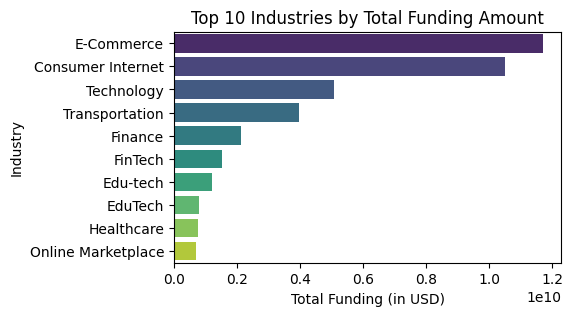

In [37]:
top_industries = industry_funding.head(10)

plt.figure(figsize=(5, 3))
sns.barplot(x='Amt (in USD)', y='IndustryVertical', data=top_industries, hue='IndustryVertical', dodge=False, palette='viridis', legend=False)
plt.title('Top 10 Industries by Total Funding Amount')
plt.xlabel('Total Funding (in USD)')
plt.ylabel('Industry')
plt.show()

##### M. The range of total investors for startups in the dataset

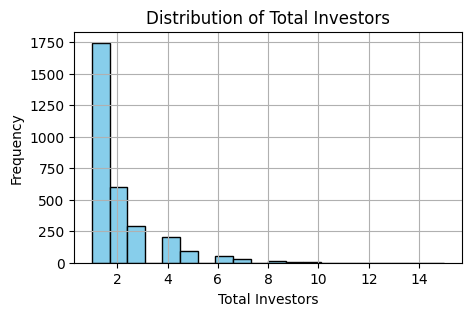

Range of total investors: (1, 15)


In [38]:
t_investors = Data['Total Investors']

plt.figure(figsize=(5, 3))
plt.hist(t_investors, bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Total Investors')
plt.xlabel('Total Investors')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


range = (t_investors.min(), t_investors.max())
print("Range of total investors:", range)


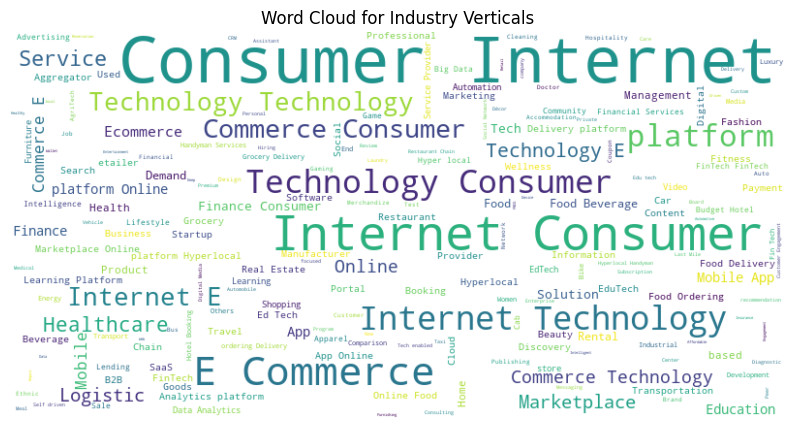

In [82]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(Data['IndustryVertical'].dropna()))
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Industry Verticals')
plt.show()

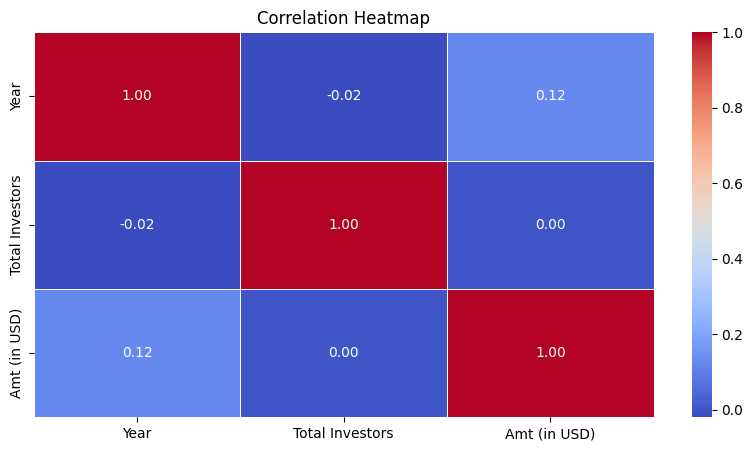

In [115]:
numerical_columns = Data.select_dtypes(include=[np.number])

correlation_matrix = numerical_columns.corr()
plt.figure(figsize=(10, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

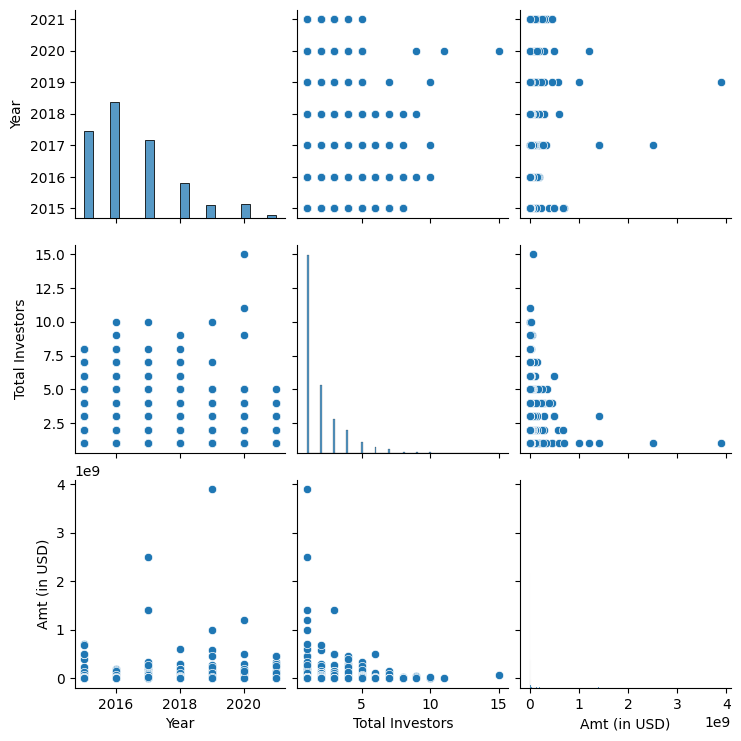

In [42]:
sns.pairplot(Data)
plt.show()

In [43]:
Data.groupby('CityLocation')['Amt (in USD)'].mean()

CityLocation
Agra             6.445311e+06
Ahemadabad       3.172406e+06
Ahemdabad        1.932969e+07
Ahmedabad        6.538053e+06
Amritsar         3.000000e+05
                     ...     
Uttar Pradesh    2.287129e+07
Vadodara         5.676385e+06
Varanasi         5.200000e+04
Washington       1.600000e+08
Wilmington       4.500000e+06
Name: Amt (in USD), Length: 111, dtype: float64